In [1]:
import tensorflow.examples.tutorials.mnist as mnist
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random

In [2]:
%matplotlib inline

#### Dataset info

In [3]:
# source: http://yann.lecun.com/exdb/mnist/
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10

#### Loading files
Data is already preprocessed, shuffled and normalized.

In [4]:
mnist_dataset = mnist.input_data.read_data_sets('tensorflow/examples/tutorials/mnist', 
                                                one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting tensorflow/examples/tutorials/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting tensorflow/examples/tutorials/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting tensorflow/examples/tutorials/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting tensorflow/examples/tutorials/mnist/t10k-labels-idx1-ubyte.gz


#### Divide data

In [5]:
trainX = mnist_dataset.train.images
valX = mnist_dataset.validation.images
testX = mnist_dataset.test.images

trainY = mnist_dataset.train.labels.astype(np.float32)
valY = mnist_dataset.validation.labels.astype(np.float32)
testY = mnist_dataset.test.labels.astype(np.float32)

In [6]:
TRAIN_IMAGES_NUM = trainX.shape[0]
TEST_IMAGES_NUM = testX.shape[0]

#### Present data

In [7]:
def show_digit(trainX, trainY, index):
    image = trainX[index].reshape([IMAGE_WIDTH, IMAGE_HEIGHT])
    label = trainY[index]
    plt.title("Training data, index: {},  Label: {}".format(index, label))
    plt.imshow(image, cmap="gray_r")
    plt.show()

trainX shape: (55000, 784)
trainY shape: (55000, 10)
valX shape: (5000, 784)
valY shape: (5000, 10)
testX shape: (10000, 784)
testY shape: (10000, 10)


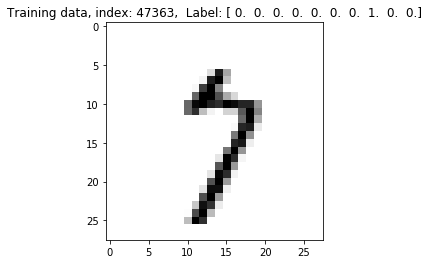

In [8]:
print("trainX shape: " + str(trainX.shape))
print("trainY shape: " + str(trainY.shape))
print("valX shape: " + str(valX.shape))
print("valY shape: " + str(valY.shape))
print("testX shape: " + str(testX.shape))
print("testY shape: " + str(testY.shape))
show_digit(trainX, trainY, np.random.randint(1, TRAIN_IMAGES_NUM + 1))

#### Neural Network preparation

In [9]:
input_nodes = IMAGE_WIDTH * IMAGE_HEIGHT
hidden_layer_1_nodes = 300
hidden_layer_2_nodes = 75
output_layer_nodes = NUM_LABELS 

In [10]:
# reset tensorflow graph
tf.reset_default_graph()

# placeholders for inputs, labels and learning rate
inputs_ = tf.placeholder(tf.float32, [None, input_nodes], name="inputs")
targets_ = tf.placeholder(tf.float32, [None, output_layer_nodes], name="targets")
learning_rate_ = tf.placeholder(tf.float32, None, name="learning_rate")
keep_prob_ = tf.placeholder(tf.float32, name="keep_prob")

# init layer input to hidden 1 - weights and biases
layer_1_weight_shape = [input_nodes, hidden_layer_1_nodes]
weights_input_to_h1_min = -1/np.sqrt(input_nodes)
weights_input_to_h1_max = 1/np.sqrt(input_nodes)

weights_input_to_h1 = tf.Variable(tf.random_uniform(
    layer_1_weight_shape, weights_input_to_h1_min, weights_input_to_h1_max), name="w_i_h1")

bias_input_to_h1 = tf.Variable(tf.zeros([hidden_layer_1_nodes]), name="b_i_h1")

# init layer hidden 1 to hidden 2 - weights and biases
layer_2_weight_shape = [hidden_layer_1_nodes, hidden_layer_2_nodes]
weights_h1_to_h2_min = -1/np.sqrt(hidden_layer_1_nodes)
weights_h1_to_h2_max = 1/np.sqrt(hidden_layer_1_nodes)

weights_h1_to_h2 = tf.Variable(tf.random_uniform(
    layer_2_weight_shape, weights_h1_to_h2_min, weights_h1_to_h2_max), name="w_h1_h2")

bias_h1_to_h2 = tf.Variable(tf.zeros([hidden_layer_2_nodes]), name="b_h1_h2")

# init hidden 2 to output - weights and biases
layer_3_weight_shape = [hidden_layer_2_nodes, output_layer_nodes]
weights_h2_to_o_min = -1/np.sqrt(hidden_layer_2_nodes)
weights_h2_to_o_max = 1/np.sqrt(hidden_layer_2_nodes)

weights_h2_to_o = tf.Variable(tf.random_uniform(
    layer_3_weight_shape, weights_h2_to_o_min, weights_h2_to_o_max), name="w_h2_o")

bias_h2_to_o = tf.Variable(tf.zeros([output_layer_nodes]), name="b_h2_o")

# layers
input_to_h1_layer = tf.matmul(inputs_, weights_input_to_h1) + bias_input_to_h1
input_to_h1_layer_activated = tf.nn.relu(input_to_h1_layer)
input_to_h1_layer_activated = tf.nn.dropout(input_to_h1_layer_activated, keep_prob_)

h1_to_h2_layer = tf.matmul(input_to_h1_layer_activated, weights_h1_to_h2) + bias_h1_to_h2
h1_to_h2_layer_activated = tf.nn.relu(h1_to_h2_layer)
h1_to_h2_layer_activated = tf.nn.dropout(h1_to_h2_layer_activated, keep_prob_)

h2_to_o_layer_logits = tf.matmul(h1_to_h2_layer_activated, weights_h2_to_o) + bias_h2_to_o

#### Loss and accuracy assessment

In [11]:
# loss function
loss_function = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=h2_to_o_layer_logits, labels=targets_))

# gradient descent optimiser
optimizer = tf.train.GradientDescentOptimizer(learning_rate_).minimize(loss_function)

# accuracy
correct_prediction = tf.equal(tf.argmax(h2_to_o_layer_logits, 1), tf.argmax(targets_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#### Batch preparation

My own implementation:

In [12]:
def prepare_mini_batches(data, labels, batch_size):
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    mini_batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return mini_batches

In [13]:
# divide trainX, trainY data into batches of size 128, data is copied
mini_batches_example = prepare_mini_batches(trainX, trainY, 128)

# pop next batches
exampleX_batches, exampleY_batches = mini_batches_example.pop()
print("Input data mini-batch: " + str(exampleX_batches.shape))
print("Input data labels mini-batch: " + str(exampleY_batches.shape))

Input data mini-batch: (128, 784)
Input data labels mini-batch: (128, 10)


Similar but <u>NOT THE SAME</u> result could be achieved by using `mnist_dataset.train` object.

In [14]:
# fetching next 128 size RANDOM batches from data in mnist_dataset.traing
tf_exampleX_batches, tf_exampleY_batches = mnist_dataset.train.next_batch(128)
print("Input data mini-batch: " + str(tf_exampleX_batches.shape))
print("Input data labels mini-batch: " + str(tf_exampleY_batches.shape))

Input data mini-batch: (128, 784)
Input data labels mini-batch: (128, 10)


Main difference between two approaches is:

a) With my implementation you make sure that if you iterate over *mini_batches* received from *prepare_mini_batches* function - your whole train data will be inserted into net but with random order. 

b) With tensorflow implementation you simply receive randomly picked *batch_size* samples. That way it is possible that some of samples from train set will enter net more often than others.

#### Hyperparameters

In [15]:
epochs = 65
batch_size = 128
learning_rate = 0.05
keep_prob = 0.5

####  Training cycle

In [16]:
session = tf.Session()

In [17]:
info = {'train':[], 'validation':[], 'train_acc':[], 'validation_acc':[]}

session.run(tf.global_variables_initializer())
for epoch in range(epochs):
    mini_batches = prepare_mini_batches(trainX, trainY, batch_size)

    epoch_losses = []
    epoch_accuracy = []
    while mini_batches:
        data_inputs, data_labels = mini_batches.pop()

        session.run(
            optimizer, feed_dict={inputs_: data_inputs, 
                                  targets_: data_labels, 
                                  learning_rate_: learning_rate,
                                  keep_prob_: keep_prob})

        batch_loss = session.run(
            loss_function, feed_dict={inputs_: data_inputs, 
                                      targets_: data_labels,
                                      keep_prob_: 1.})

        batch_acc = session.run(accuracy, feed_dict={inputs_:data_inputs, 
                                                              targets_: data_labels,
                                                              keep_prob_: 1.})

        epoch_losses.append(batch_loss)
        epoch_accuracy.append(batch_acc)

    train_loss = np.mean(epoch_losses)
    info['train'].append(train_loss)

    train_accuracy = np.mean(epoch_accuracy)
    info['train_acc'].append(train_accuracy)

    val_loss = session.run(loss_function, feed_dict={inputs_: valX, 
                                                              targets_: valY,
                                                              keep_prob_: 1.})
    info['validation'].append(val_loss)

    val_accuracy = session.run(accuracy, feed_dict={inputs_: valX,
                                                             targets_: valY,
                                                             keep_prob_: 1.})
    info['validation_acc'].append(val_accuracy)

    print("Epoch: " + str(epoch + 1) + "/" + str(epochs) + ":\n"
          + "      - Training loss: " + str(train_loss) + " (acc: " + str(train_accuracy) + ")\n"
          + "      - Validation loss: " + str(val_loss) + " (acc: " + str(val_accuracy) + ")")

Epoch: 1/65:
      - Training loss: 1.14778 (acc: 0.717821)
      - Validation loss: 0.486557 (acc: 0.8764)
Epoch: 2/65:
      - Training loss: 0.389732 (acc: 0.894959)
      - Validation loss: 0.323815 (acc: 0.9112)
Epoch: 3/65:
      - Training loss: 0.292478 (acc: 0.917668)
      - Validation loss: 0.261096 (acc: 0.9274)
Epoch: 4/65:
      - Training loss: 0.239951 (acc: 0.931144)
      - Validation loss: 0.217409 (acc: 0.9398)
Epoch: 5/65:
      - Training loss: 0.203764 (acc: 0.941106)
      - Validation loss: 0.187195 (acc: 0.9486)
Epoch: 6/65:
      - Training loss: 0.176166 (acc: 0.94859)
      - Validation loss: 0.168334 (acc: 0.9518)
Epoch: 7/65:
      - Training loss: 0.156396 (acc: 0.954418)
      - Validation loss: 0.153051 (acc: 0.9584)
Epoch: 8/65:
      - Training loss: 0.13935 (acc: 0.960118)
      - Validation loss: 0.138312 (acc: 0.9626)
Epoch: 9/65:
      - Training loss: 0.126407 (acc: 0.963105)
      - Validation loss: 0.130054 (acc: 0.965)
Epoch: 10/65:
      - T

#### Results

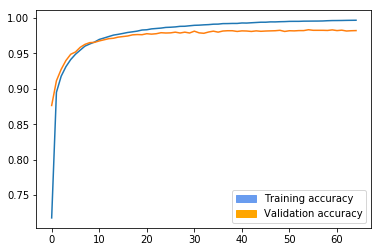

In [18]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['train_acc'], label='Training acc')
ax1.plot(info['validation_acc'], label='Validation acc')
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

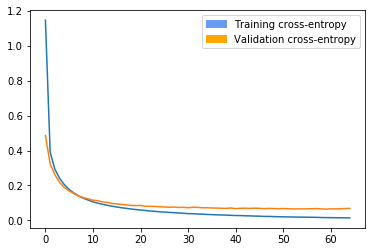

In [19]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['train'], label='Training loss')
ax2.plot(info['validation'], label='Validation loss')
blue_patch = mpatches.Patch(color='#699cef', label='Training cross-entropy')
orange_patch = mpatches.Patch(color='orange', label='Validation cross-entropy')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

In [20]:
test_accuracy = session.run(accuracy, feed_dict={inputs_: testX, 
                                                 targets_: testY,
                                                 keep_prob_: 1.})
print("Test dataset accuracy: " + str(test_accuracy))

Test dataset accuracy: 0.9794


In [21]:
session.close()